# Cubing steps with PyKOALA

This tutorial is currently used for testing purposes.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
from pykoala import __version__
import warnings

# You may want to comment the following line
warnings.filterwarnings("ignore")

from pykoala.instruments.koala_ifu import koala_rss
from pykoala.cubing import build_cube, build_wcs
# pyKOALA version
print("pyKOALA version: ", __version__)

pyKOALA version:  0.8.0+14.gb70d00e.dirty


## Load the data

In [2]:
# List of RSS objects
std_star_rss = []
aaomega_arms = {'blue': 1, 'red': 2}
# Choose which arm of the spectrograph is going to be used
arm = 'red'
path_to_data = 'data'

for i in [28, 29, 30]:
    filename = f"{path_to_data}/27feb{aaomega_arms[arm]}00{i}red.fits"
    rss = koala_rss(filename)
    std_star_rss.append(rss)

star_name = rss.info['name'].split(' ')[0]
print("Star name: ", star_name)

Star name:  HILT600


In [3]:
from pykoala.corrections.astrometry import AstrometryCorrection

astrom_corr = AstrometryCorrection()

offsets, fig = astrom_corr.register_centroids(std_star_rss, object_name=star_name,
                                         qc_plot=True, centroider='gauss')
for offset in offsets:
    print("Offset (ra, dec) in arcsec: ", offset[0].to('arcsec'), offset[1].to('arcsec'))

[Correction: Astrometry] Reference star position:  <SkyCoord (ICRS): (ra, dec) in deg
    (101.30571895, 2.13741257)>
[Registration]  Data provided in RSS format --> creating a dummy datacube
[Cubing] Constructing cube WCS
[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 98, 52)
[Cubing] Smoothing kernel scale: 4 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for information in the primary header
NOT IMPLEMENTED
[Cube] Constructing WCS
[Cube] Constructing wavelength array
[Correction: Astrometry] Offset found (ra, dec):  3.34654 arcsec -2.56846 arcsec  (arcsec)
[Registration]  Data provided in RSS format --> creating a dummy datacube
[Cubing] Constructing cube WCS
[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 98, 52)
[Cubing] Smoothing kernel scale: 4 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for information in the primary header
NOT IMPLEMENTED
[Cube] Const

<Figure size 697.385x431.008 with 0 Axes>

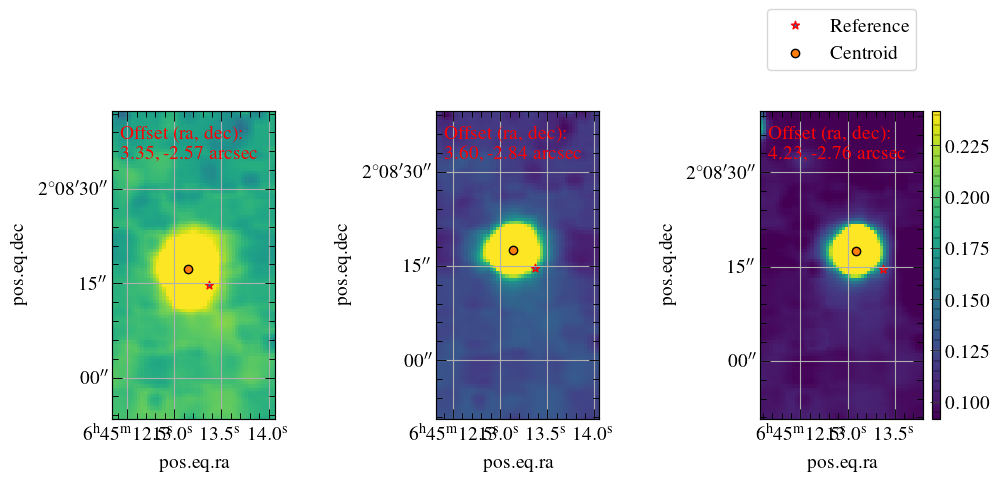

In [4]:
fig

In [5]:
# for rss, offset in zip(std_star_rss, offsets):
#     astrom_corr.apply(rss, offset=offset)

# # Check that the corrections has been logged
# print(rss.history)

In [6]:
offsets, fig = astrom_corr.register_crosscorr(std_star_rss, qc_plot=True)
for offset in offsets:
    print("Offset (ra, dec) in arcsec: ", offset[0].to('arcsec'), offset[1].to('arcsec'))

[Correction: Astrometry] Performing image cross-correlation
[Cubing] Constructing cube WCS
[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 164, 86)
[Cubing] Smoothing kernel scale: 7 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for information in the primary header
NOT IMPLEMENTED
[Cube] Constructing WCS
[Cube] Constructing wavelength array
[Cubing] Constructing cube WCS
[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 164, 86)
[Cubing] Smoothing kernel scale: 7 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for information in the primary header
NOT IMPLEMENTED
[Cube] Constructing WCS
[Cube] Constructing wavelength array
[Cubing] Constructing cube WCS
[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 164, 86)
[Cubing] Smoothing kernel scale: 7 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for informatio

<Figure size 697.385x431.008 with 0 Axes>

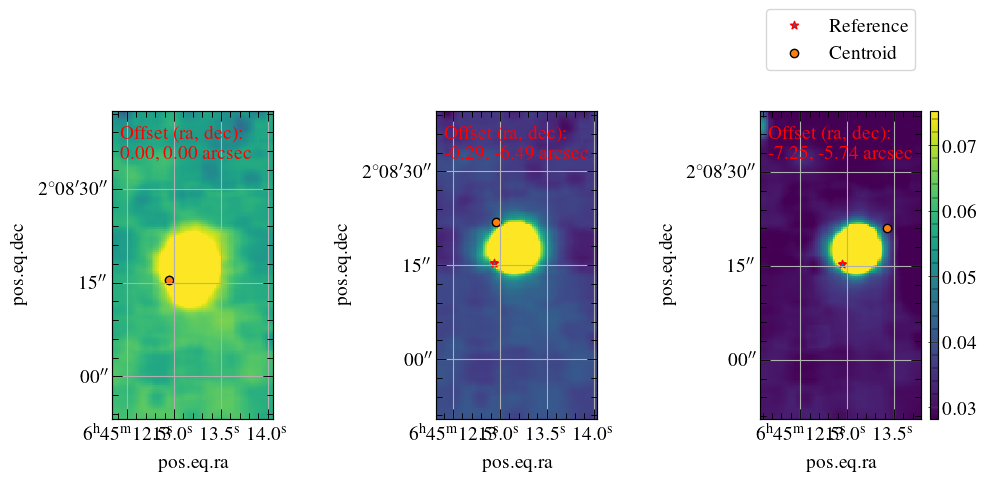

In [7]:
fig

For interpolating RSS data into a 3D datacube we will make use of the function *build_cube*. This method requires as input:
- A list of RSS objects. 
- The desired dimensions of the cube expressed as a 2-element tuple, corresponding to (ra, dec) in arcseconds.
- The pixel size of the cube in arcseconds.
- A list containing the ADR correction for every RSS (it can contain None) in the form: [(ADR_ra_1, ADR_dec_1), (ADR_ra_2, ADR_dec_2), (None, None)].
- Additional information to be included in *cube_info*

In [8]:
datacube_shape = (std_star_rss[0].wavelength.size, 40, 60)
ref_position = (std_star_rss[0].wavelength[0], np.mean(std_star_rss[0].info['fib_ra']), np.mean(std_star_rss[0].info['fib_dec']))  # (deg, deg)
spatial_pixel_size = 1.0 / 3600  # (deg)
spectral_pixel_size = std_star_rss[0].wavelength[1] - std_star_rss[0].wavelength[0]  # (angstrom)

print(f"Creating a WCS with\n position: {ref_position}\n Spatial pixel size: {spatial_pixel_size}\n Spectral pixel size: {spectral_pixel_size}")

wcs = build_wcs(datacube_shape=datacube_shape,
                reference_position=ref_position,
                spatial_pix_size=spatial_pixel_size,
                spectra_pix_size=spectral_pixel_size,
            )

Creating a WCS with
 position: (6080.95886230418, 101.30494315927109, 2.138272986144285)
 Spatial pixel size: 0.0002777777777777778
 Spectral pixel size: 1.5751823123400754
[Cubing] Constructing cube WCS


In [12]:
cube = build_cube(rss_set=std_star_rss,
                  wcs=wcs,
                  kernel_size_arcsec=1.0)

print(cube.hdul.info())
white_image = np.nanmean(cube.intensity, axis=0)

[Cubing] Starting cubing process
[Cubing] Initialising new datacube with dimensions: (2048, 60, 40)
[Cubing] Smoothing kernel scale: 2 (pixels)
[Cubing] Smoothing kernel scale: 2 (pixels)
[Cubing] Smoothing kernel scale: 2 (pixels)
[Cube] Initialising cube with input HDUL
[Cube] Looking for information in the primary header
NOT IMPLEMENTED
[Cube] Constructing WCS
[Cube] Constructing wavelength array
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  FLUX          1 ImageHDU        29   (40, 60, 2048)   float64   
  2  VARIANCE      1 ImageHDU        29   (40, 60, 2048)   float64   
None


In [10]:
from pykoala.corrections.astrometry import find_centroid_in_dc

pos_com = find_centroid_in_dc(cube, centroider='com', com_power=1.)
pos_com_3 = find_centroid_in_dc(cube, centroider='com', com_power=3.)
pos_gauss = find_centroid_in_dc(cube, centroider='gauss')

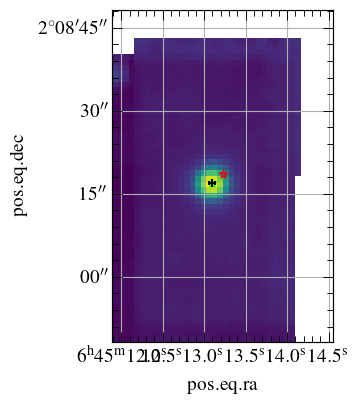

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs.celestial)
ax.imshow(np.log10(white_image))
ax.scatter(pos_com.ra, pos_com.dec, marker='*', ec='r', transform=ax.get_transform('world'))
ax.scatter(pos_com_3.ra, pos_com_3.dec, marker='*', ec='lime', transform=ax.get_transform('world'))
ax.scatter(pos_gauss.ra, pos_gauss.dec, marker='+', ec='k', transform=ax.get_transform('world'))
